# 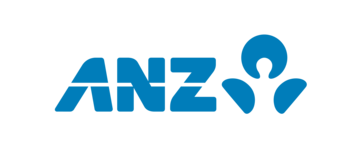 ANZ Predictive Analytics by Renzo https://nextslim.github.io/RenzOnly/ <hr>

Using the same transaction dataset, identify the annual salary for each customer

Explore correlations between annual salary and various customer attributes (e.g. age). These attributes could be those that are readily available in the data (e.g. age) or those that you construct or derive yourself (e.g. those relating to purchasing behaviour). Visualise any interesting correlations using a scatter plot.

Build a simple regression model to predict the annual salary for each customer using the attributes you identified above

How accurate is your model? Should ANZ use it to segment customers (for whom it does not have this data) into income brackets for reporting purposes?

For a challenge: build a decision-tree based model to predict salary. Does it perform better? How would you accurately test the performance of this model?

### Import Dependencies

In [55]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

import pyforest
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.metrics import accuracy_score

import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn import tree


### Loading the Data

In [21]:
# Create a reference to the Xlsx and import it into a Pandas DataFrame
df = pd.read_excel("ANZdataset.xlsx", engine='openpyxl')
df.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,...,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.00,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,nan,Diana,...,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
1,authorized,0.00,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,nan,Diana,...,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit
2,authorized,1.00,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,nan,Michael,...,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit
3,authorized,1.00,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,nan,Rhonda,...,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit
4,authorized,1.00,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,nan,Diana,...,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit


### General Analysis of the Data

In [22]:
# Exploring the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12043 entries, 0 to 12042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   status             12043 non-null  object        
 1   card_present_flag  7717 non-null   float64       
 2   bpay_biller_code   885 non-null    object        
 3   account            12043 non-null  object        
 4   currency           12043 non-null  object        
 5   long_lat           12043 non-null  object        
 6   txn_description    12043 non-null  object        
 7   merchant_id        7717 non-null   object        
 8   merchant_code      883 non-null    float64       
 9   first_name         12043 non-null  object        
 10  balance            12043 non-null  float64       
 11  date               12043 non-null  datetime64[ns]
 12  gender             12043 non-null  object        
 13  age                12043 non-null  int64         
 14  mercha

In [23]:
#Converting the date column to pandas timestamp format
df['date'] = pd.to_datetime(df['date'])
print(df['date'].dtype)
print(type(df['date'][0]))
df['date'].head()

datetime64[ns]
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


0   2018-08-01
1   2018-08-01
2   2018-08-01
3   2018-08-01
4   2018-08-01
Name: date, dtype: datetime64[ns]

In [24]:
# Generate descriptive statistics
df.describe()

,card_present_flag,merchant_code,balance,age,amount
count,7717.00,883.00,12043.00,12043.00,12043.00
mean,0.80,0.00,14704.20,30.58,187.93
std,0.40,0.00,31503.72,10.05,592.60
min,0.00,0.00,0.24,18.00,0.10
25%,1.00,0.00,3158.59,22.00,16.00
50%,1.00,0.00,6432.01,28.00,29.00
75%,1.00,0.00,12465.94,38.00,53.66
max,1.00,0.00,267128.52,78.00,8835.98


 ### General Cleaning <hr>

In [25]:
#checking if there are any missing values in the entire data set 
df.isnull().values.any()

True

#### Missing Data Heatmap

<AxesSubplot:title={'center':'Data Heatmap for the Missing data in the data set'}>

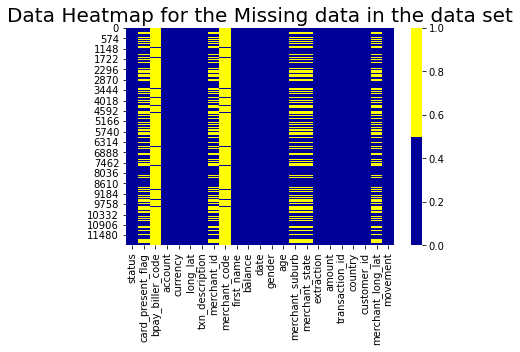

In [26]:
cols = df.columns[:30] # first 30 columns
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
plt.title('Data Heatmap for the Missing data in the data set', fontsize=20)
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

#### Missing Data Percentage List

In [27]:
# if it's a larger dataset and the visualization takes too long can do this.
# % of missing.
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

status - 0%
card_present_flag - 36%
bpay_biller_code - 93%
account - 0%
currency - 0%
long_lat - 0%
txn_description - 0%
merchant_id - 36%
merchant_code - 93%
first_name - 0%
balance - 0%
date - 0%
gender - 0%
age - 0%
merchant_suburb - 36%
merchant_state - 36%
extraction - 0%
amount - 0%
transaction_id - 0%
country - 0%
customer_id - 0%
merchant_long_lat - 36%
movement - 0%


 #### Removing columns which gives no valuable analysis

In [28]:
#bpay_biller_code and merchant code has 90% NA values. 
#For better analysis either dropping them or ignoring them is best to do.
empty = ['merchant_id', 'bpay_biller_code', 'merchant_code', 'long_lat']
df.drop(empty, axis = 1, inplace = True)

 #### Check outliers by using scatter plot

There are some outliers like values but they are transations above the average. There is not need to remove them


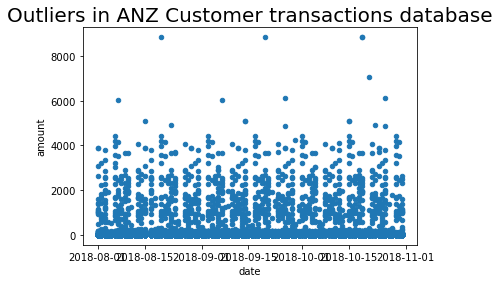

In [29]:
df.plot(kind='scatter', x='date', y='amount')
plt.title('Outliers in ANZ Customer transactions database', fontsize=20)
print("There are some outliers like values but they are transations above the average. There is not need to remove them")

## General Salary Insights<hr>

Total Salary: 1676576.85
Total Spending: 586707.35


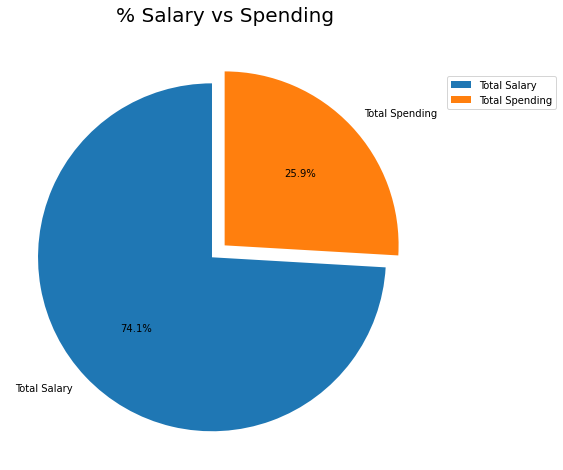

In [30]:
# Salary vs Spending

total_salary = df.amount[(df.movement == "credit")].sum() 
total_spending = df.amount[(df.movement == "debit")].sum()
print("Total Salary:",total_salary)
print("Total Spending:", total_spending)
pie = [total_salary, total_spending]
fig, ax = plt.subplots(figsize=(12,8))
label = ['Total Salary',
        'Total Spending']
explode = (0.1, 0)
ax.pie(pie, autopct="%.1f%%", labels =  label, explode = explode,startangle=90 )
plt.title('% Salary vs Spending', fontsize=20)
ax.legend(frameon=True, bbox_to_anchor=(1,0.9))
plt.show()

 ## CREATION OF A NEW DATA FRAME<hr>

In [31]:
df['txn_description'].unique()

array(['POS', 'SALES-POS', 'PAYMENT', 'INTER BANK', 'PAY/SALARY',
       'PHONE BANK'], dtype=object)

In [32]:
salaries = df[df["txn_description"] == "PAY/SALARY"].groupby("customer_id").mean()
salaries.head()

,card_present_flag,balance,age,amount
customer_id,,,,
CUS-1005756958,nan,4718.67,53,970.47
CUS-1117979751,nan,11957.20,21,3578.65
CUS-1140341822,nan,5841.72,28,1916.51
CUS-1147642491,nan,8813.47,34,1711.39
CUS-1196156254,nan,23845.72,34,3903.73


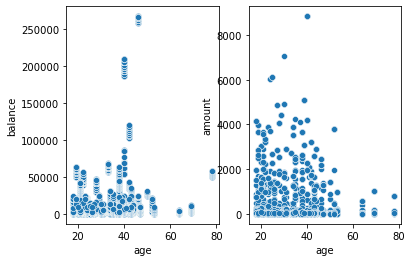

In [66]:
fig, ax = plt.subplots(1, 2)

sns.scatterplot(x=df.age, y=df.balance, ax = ax[0])
sns.scatterplot(x=df.age, y=df.amount, ax= ax[1])

fig.show()

 ### Calculation of the Anual Salary

In [33]:
#
sal =[]
for customer_id in df['customer_id']:
    sal.append(int(salaries.loc[customer_id]['amount'].sum()))
df['annual_salary'] = sal
df.head()

,status,card_present_flag,account,currency,txn_description,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement,annual_salary
0,authorized,1.00,ACC-1598451071,AUD,POS,Diana,35.39,2018-08-01,F,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit,1013
1,authorized,0.00,ACC-1598451071,AUD,SALES-POS,Diana,21.20,2018-08-01,F,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit,1013
2,authorized,1.00,ACC-1222300524,AUD,POS,Michael,5.71,2018-08-01,M,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit,1002
3,authorized,1.00,ACC-1037050564,AUD,SALES-POS,Rhonda,2117.22,2018-08-01,F,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit,892
4,authorized,1.00,ACC-1598451071,AUD,SALES-POS,Diana,17.95,2018-08-01,F,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit,1013


 ### New data frame(Salary)

In [62]:
salary = df[df['txn_description'] == 'PAY/SALARY']
salary.head()

,status,card_present_flag,account,currency,txn_description,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement,annual_salary
50,posted,nan,ACC-588564840,AUD,PAY/SALARY,Isaiah,8342.11,2018-08-01,M,23,NaN,NaN,2018-08-01T11:00:00.000+0000,3903.95,9ca281650e5d482d9e53f85e959baa66,Australia,CUS-1462656821,NaN,credit,3903
61,posted,nan,ACC-1650504218,AUD,PAY/SALARY,Marissa,2040.58,2018-08-01,F,23,NaN,NaN,2018-08-01T12:00:00.000+0000,1626.48,1822eb0e1bbe4c9e95ebbb0fa2cc4323,Australia,CUS-2500783281,NaN,credit,1626
64,posted,nan,ACC-3326339947,AUD,PAY/SALARY,Eric,3158.51,2018-08-01,M,22,NaN,NaN,2018-08-01T12:00:00.000+0000,983.36,bd62b1799a454cedbbb56364f7c40cbf,Australia,CUS-326006476,NaN,credit,983
68,posted,nan,ACC-3541460373,AUD,PAY/SALARY,Jeffrey,2517.66,2018-08-01,M,24,NaN,NaN,2018-08-01T13:00:00.000+0000,1408.08,0d95c7c932bb48e5b44c2637bdd3efe9,Australia,CUS-1433879684,NaN,credit,1408
70,posted,nan,ACC-2776252858,AUD,PAY/SALARY,Kristin,2271.79,2018-08-01,F,43,NaN,NaN,2018-08-01T13:00:00.000+0000,1068.04,f50ccf1195214d14a0acbfcb5a265193,Australia,CUS-4123612273,NaN,credit,1068


### Checking missing or unnecessary values in the New data frame(Salary)

In [35]:
# if it's a larger dataset and the visualization takes too long can do this.
# % of missing.
for col in salary.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

status - 0%
card_present_flag - 36%
account - 0%
currency - 0%
txn_description - 0%
first_name - 0%
balance - 0%
date - 0%
gender - 0%
age - 0%
merchant_suburb - 36%
merchant_state - 36%
extraction - 0%
amount - 0%
transaction_id - 0%
country - 0%
customer_id - 0%
merchant_long_lat - 36%
movement - 0%
annual_salary - 0%


In [36]:
#  4 columns have missing values hence, we will drop these columns

salary.drop(['card_present_flag', "merchant_suburb","merchant_state", 'merchant_long_lat'], axis = 1, inplace = True)

In [37]:
salary.head()

,status,account,currency,txn_description,first_name,balance,date,gender,age,extraction,amount,transaction_id,country,customer_id,movement,annual_salary
50,posted,ACC-588564840,AUD,PAY/SALARY,Isaiah,8342.11,2018-08-01,M,23,2018-08-01T11:00:00.000+0000,3903.95,9ca281650e5d482d9e53f85e959baa66,Australia,CUS-1462656821,credit,3903
61,posted,ACC-1650504218,AUD,PAY/SALARY,Marissa,2040.58,2018-08-01,F,23,2018-08-01T12:00:00.000+0000,1626.48,1822eb0e1bbe4c9e95ebbb0fa2cc4323,Australia,CUS-2500783281,credit,1626
64,posted,ACC-3326339947,AUD,PAY/SALARY,Eric,3158.51,2018-08-01,M,22,2018-08-01T12:00:00.000+0000,983.36,bd62b1799a454cedbbb56364f7c40cbf,Australia,CUS-326006476,credit,983
68,posted,ACC-3541460373,AUD,PAY/SALARY,Jeffrey,2517.66,2018-08-01,M,24,2018-08-01T13:00:00.000+0000,1408.08,0d95c7c932bb48e5b44c2637bdd3efe9,Australia,CUS-1433879684,credit,1408
70,posted,ACC-2776252858,AUD,PAY/SALARY,Kristin,2271.79,2018-08-01,F,43,2018-08-01T13:00:00.000+0000,1068.04,f50ccf1195214d14a0acbfcb5a265193,Australia,CUS-4123612273,credit,1068


In [38]:
#  others columns that are repeditive and he imapct of these values can not be identify on target column hence deleting them.

salary.drop(['status','account','currency', 'first_name',"txn_description","extraction","transaction_id","movement","country" ], axis = 1, inplace = True)

In [39]:
salary.head()

,balance,date,gender,age,amount,customer_id,annual_salary
50,8342.11,2018-08-01,M,23,3903.95,CUS-1462656821,3903
61,2040.58,2018-08-01,F,23,1626.48,CUS-2500783281,1626
64,3158.51,2018-08-01,M,22,983.36,CUS-326006476,983
68,2517.66,2018-08-01,M,24,1408.08,CUS-1433879684,1408
70,2271.79,2018-08-01,F,43,1068.04,CUS-4123612273,1068


 ### Confirming the of Costumers 

In [40]:
# Unique Costumers
salary.customer_id.nunique()

100

In [41]:
 ### Gender as # Value

In [42]:
salary['gender'] = pd.get_dummies(salary['gender'], drop_first=True)

## CORRELATION HEATMAP<hr>

<AxesSubplot:>

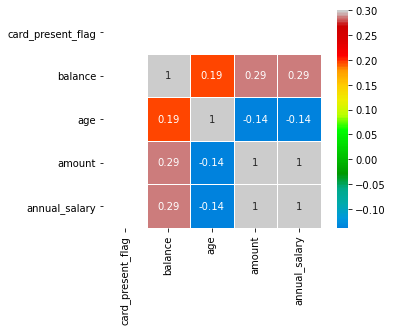

In [91]:
# Plotting the correlation heatmap 
sns.heatmap(salary.corr() ,vmax=.3 ,annot=True, center=0, cmap="nipy_spectral", square=True, linewidths=.5)

## Anual Salary with Multi Linear Regression
*************


In [44]:
salary.head()

,balance,date,gender,age,amount,customer_id,annual_salary
50,8342.11,2018-08-01,1,23,3903.95,CUS-1462656821,3903
61,2040.58,2018-08-01,0,23,1626.48,CUS-2500783281,1626
64,3158.51,2018-08-01,1,22,983.36,CUS-326006476,983
68,2517.66,2018-08-01,1,24,1408.08,CUS-1433879684,1408
70,2271.79,2018-08-01,0,43,1068.04,CUS-4123612273,1068


In [57]:
# Assign the data to X and y

# X = salary[[ "balance","amount","age"]]
X = salary.drop(["date",'annual_salary',"customer_id"],axis=1)
y = salary["annual_salary"].values.reshape(-1, 1)
print(X.shape, y.shape)

(883, 4) (883, 1)


In [46]:
# Use train_test_split to create training and testing data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)



In [47]:
# Create the model using LinearRegression

from sklearn.linear_model import LinearRegression
model = LinearRegression()


In [48]:
# Fit the model to the training data and calculate the scores for the training and testing data

model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)


print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.9999999420800842
Testing Score: 0.9999999525471684


In [73]:
print('Salary coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_) 

Salary coefficients:  [[-6.57390380e-07 -5.93878747e-02  6.04764485e-03  9.99984354e-01]]
y-axis intercept:  [-0.60707937]


Text(0.5, 1.0, 'Residual Plot')

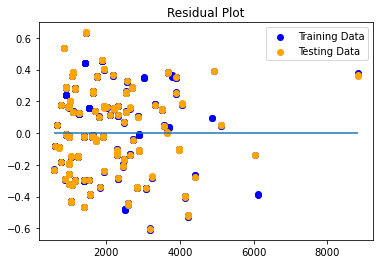

In [49]:
# Plot the Residuals for the Training and Testing data

plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot")


In [50]:
# Call the `score` method on the model to show the r2 score

model.score(X_test, y_test)


0.9999999525471684

 ### Correlations

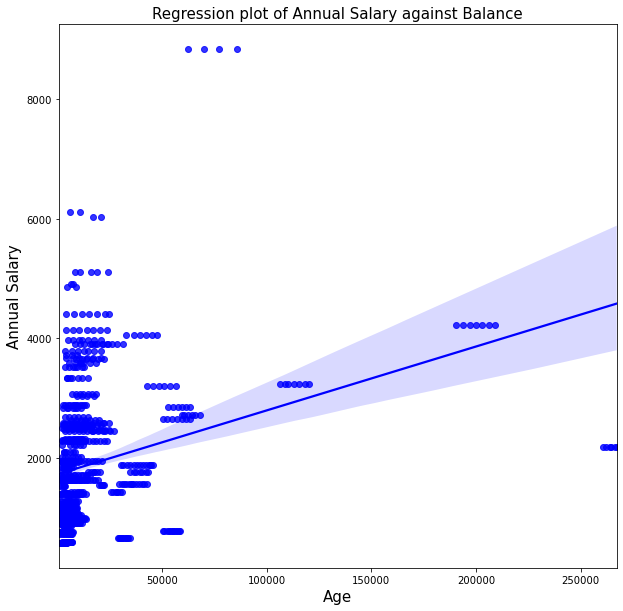

In [78]:
plt.figure(figsize=(10, 10))
sns.regplot("balance", "annual_salary", fit_reg=True, data=salary, color="b")
plt.title("Regression plot of Annual Salary against Balance", fontsize=15)
plt.xlabel("Age", fontsize=15)
plt.ylabel("Annual Salary", fontsize=15)
plt.show()

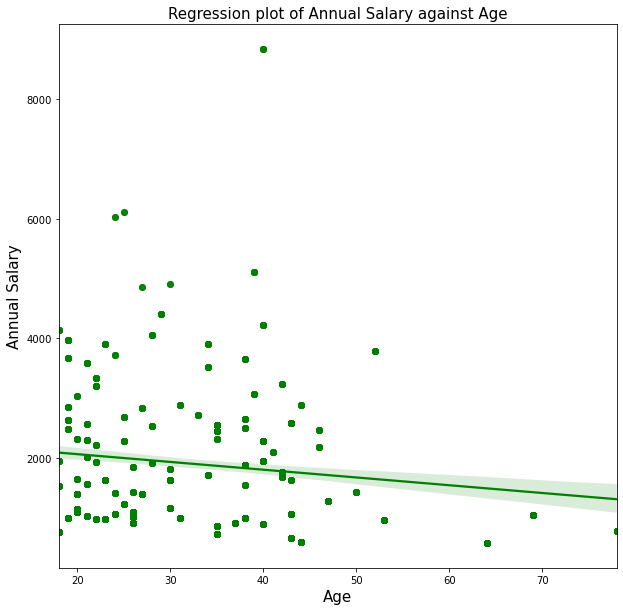

In [81]:
plt.figure(figsize=(10, 10))
sns.regplot("age", "annual_salary", fit_reg=True, data=salary, color="g")
plt.title("Regression plot of Annual Salary against Age", fontsize=15)
plt.xlabel("Age", fontsize=15)
plt.ylabel("Annual Salary", fontsize=15)
plt.show()

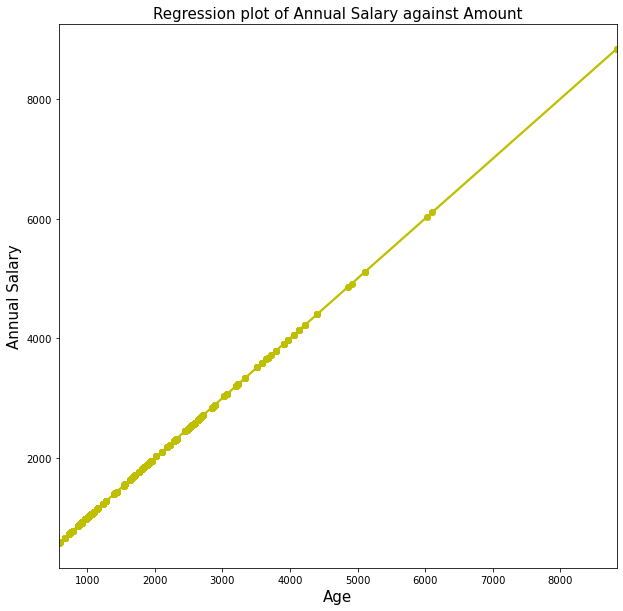

In [87]:
plt.figure(figsize=(10, 10))
sns.regplot("amount", "annual_salary", fit_reg=True, data=salary, color="y")
plt.title("Regression plot of Annual Salary against Amount", fontsize=15)
plt.xlabel("Age", fontsize=15)
plt.ylabel("Annual Salary", fontsize=15)
plt.show()

## Testing using different ML Models

In [51]:
clf = LazyClassifier(verbose=0,ignore_warnings=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:18<00:00,  1.56it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearDiscriminantAnalysis,1.00,1.00,None,1.00,0.01
ExtraTreesClassifier,1.00,1.00,None,1.00,0.13
RandomForestClassifier,1.00,1.00,None,1.00,0.19
BaggingClassifier,1.00,1.00,None,1.00,0.04
LGBMClassifier,1.00,1.00,None,1.00,14.03
DecisionTreeClassifier,1.00,1.00,None,1.00,0.01
GaussianNB,1.00,0.99,None,1.00,0.02
XGBClassifier,0.96,0.96,None,0.96,1.97
NearestCentroid,0.95,0.96,None,0.94,0.01


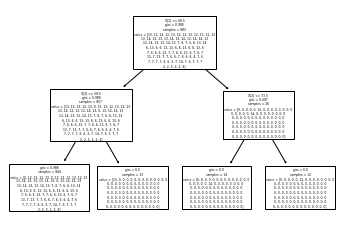

In [59]:
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(X, y)
tree.plot_tree(clf) 

print()

In [92]:
predictions = model.predict(X)
print(f"True output: {y[0]}")
print(f"Predicted output: {predictions[0]}")
print(f"Prediction Error: {predictions[0]-y[0]}")

True output: [3903]
Predicted output: [3903.35606419]
Prediction Error: [0.35606419]
